## loop through the phrogs and assign to an oligomeric state

loop through and get the oligomeric state of each phrog and then peform analysis between the annotation etc

In [4]:
# imports 
import pandas as pd 
import pickle 
import glob
import re
import numpy as np 
from collections import Counter
from tqdm import tqdm 
import glob
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# read in the metrics generated for the phrogs that pass the tests 
part_1 =  glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_001.phlegm/metrics_pickle/*.pkl')
part_2 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_002.phlegm/metrics_pickle/*.pkl')
part_3 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_003.phlegm/metrics_pickle/*.pkl')
part_4 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_004.phlegm/metrics_pickle/*.pkl')
part_5 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_005.phlegm/metrics_pickle/*.pkl')
part_6 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_006.phlegm/metrics_pickle/*.pkl') 
part_7 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_007.phlegm/metrics_pickle/*.pkl')
part_8 = glob.glob('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/nonsingleton_representative_sequences.part_008.phlegm/metrics_pickle/*.pkl')
all_parts =  part_1 + part_2 + part_3 + part_4 + part_5 + part_6 + part_7 + part_8

all_phrogs_pickle_complete = [re.split('/', p)[-1][:-4] for p in all_parts]

# make a dictionary that maps the phrog to its metrics path 
pickle_paths = dict(zip(all_phrogs_pickle_complete, all_parts)) 

# dictionary for mapping to a homo-oligomeric state 
subunits_state_dict = {1: 'Monomer', 
  2: '2-mer',  
3: '3-mer', 
4: '4-mer', 
5: '5-6-mer', 
6: '5-6-mer',
7: '7+-mer',
8: '7+-mer',
9: '7+-mer',
10: '7+-mer',
}

# read in the phrogs annotations so that these can be overlayed 
phrogs_df = pd.read_csv('/home/grig0076/scratch/databases/phrogs/phrog_annot_v4.tsv', sep='\t')
phrogs_df['phrog']  = ['phrog_' + str(p) for p in phrogs_df['phrog']] 
phrogs_category = dict(zip(phrogs_df['phrog'], phrogs_df['category']))
phrogs_annot = dict(zip(phrogs_df['phrog'], phrogs_df['annot']))

In [3]:
# read in the set of phrogs with plddt that pass threshold etc 
phrogs = pd.read_csv('../files/phrogs_pass_plddt_length_threshold.txt', sep = '\t', header=None)[0].to_list()

In [16]:
subunits_keys = ['2_subunits', '3_subunits', '4_subunits', '5_subunits', '6_subunits', '7_subunits', '8_subunits', '9_subunits', '10_subunits'] 
replicate_keys = ['rep_1', 'rep_2', 'rep_3']
metrics_df = pd.DataFrame()

for p in phrogs: 
    metrics = pickle.load(open(pickle_paths.get(p), 'rb'))
    
    for s in subunits_keys: 
        for r in replicate_keys: 
            m = metrics.get(s).get(r) 
            iptm = m.get('iptm')  
            ptm = m.get('ptm')
            mean_plddt = m.get('mean_plddt')
            mean_pdockq2 = np.mean(m.get('pdockq2'))
            mean_plddt_lst = np.mean(m.get('avgif_pae'))
            df = pd.DataFrame.from_dict({'iptm': iptm, 'ptm': ptm, 'mean_plddt':mean_plddt, 'mean_pdockq2': mean_pdockq2, 'mean_plddt_lst': mean_plddt_lst}, orient='index').T
            df['replicate'] = r
            df['subunits'] = str(int(re.split('_', s)[0]))
            df['phrog'] = p

            metrics_df = pd.concat([metrics_df, df])

In [17]:
metrics_df.to_csv('../files/all_phrogs_metrics_df.csv')

In [9]:
metrics_df = pd.read_csv('../files/all_phrogs_metrics_df.csv', index_col=0)

In [8]:
# generate predictions on these folded proteins 
phrogs_predict = list(set(metrics_df['phrog']))

# store this info in a dataframe like the others so that a prediction can be made 
iptm_predictions = pd.DataFrame() 

for p in tqdm(phrogs_predict, desc="Predicting oligomeric states"):
    dd = metrics_df[metrics_df['phrog'] == p] 
    per_subunits_iptm = dd[['iptm', 'subunits', 'mean_plddt']].groupby('subunits').mean() 
    max_iptm = per_subunits_iptm.max()[0] 
    max_iptm_subunits = int(per_subunits_iptm.idxmax()[0])
    max_iptm_subunits_plddt = per_subunits_iptm.loc[per_subunits_iptm.idxmax()[0]]['mean_plddt'] # get the plddt of this prediction 
    
    # if this max is below a threshold then say it is a monomer/can't be predicted  
    if max_iptm < 0.65 or max_iptm_subunits_plddt < 60: 
        max_iptm_subunits = 1
        
    results = pd.DataFrame.from_dict({
        'phrog': p, 
        'max_iptm': max_iptm, 
        'max_iptm_subunits': max_iptm_subunits, 
        'prediction_state_bin': subunits_state_dict.get(max_iptm_subunits)
    }, orient='index').T
    
    iptm_predictions = pd.concat([iptm_predictions, results])

# drop the predictions that are ambiguous 
iptm_predictions = iptm_predictions.dropna()

Predicting oligomeric states:   0%|          | 63/22554 [00:02<16:54, 22.16it/s]


KeyboardInterrupt: 

In [30]:
iptm_predictions.to_csv('../files/all_phrogs_iptm_predictions.csv')

In [10]:
iptm_predictions = pd.read_csv('../files/all_phrogs_iptm_predictions.csv', index_col=0)
print(len(iptm_predictions))
# add the annotation of the phrog to this dataframe 
iptm_predictions['category'] = [phrogs_category.get(p) for p in iptm_predictions['phrog']] 
iptm_predictions['annot'] = [phrogs_annot.get(p) for p in iptm_predictions['phrog']] 

# read in the symmetry predictions 
ananas = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/ananas/ananas_top_symmetry.tsv', sep='\t')
ananas['phrog'] = [a[:-2] for a in ananas['protein']]

iptm_predictions_ananas = pd.merge(
    iptm_predictions,  # first dataframe
    ananas,                # second dataframe
    on='phrog',            # column name to join on
    how='inner'            # join type: inner, left, right, outer
)

predicted_oligomers = iptm_predictions[iptm_predictions['prediction_state_bin'] != 'Monomer']
predicted_oligomers['phrog'].to_csv("../files/phrogs_predicted_oligomers.txt", index=False, header=False)

22554


In [11]:
oligomer_predictions = iptm_predictions[iptm_predictions['prediction_state_bin'] != 'Monomer']
oligomer_predictions = oligomer_predictions.reset_index().drop('index', axis=1)
oligomer_list = [oligomer_predictions.loc[i]['phrog'] + '.' + str(oligomer_predictions.loc[i]['max_iptm_subunits']) for i in range(len(oligomer_predictions))]  

# save to a text file for copying the best state 
with open('../files/phrog_oligomer_predictions.txt', 'w') as f:
    for item in oligomer_list:
        f.write(f"{item}\n") 
        
oligomer_predictions

,phrog,max_iptm,max_iptm_subunits,prediction_state_bin,category,annot
0,phrog_4989,0.793333,5,5-6-mer,unknown function,NaN
1,phrog_780,0.830000,2,2-mer,unknown function,NaN
2,phrog_3365,0.826667,2,2-mer,unknown function,NaN
3,phrog_14753,0.666667,3,3-mer,head and packaging,head fiber protein
4,phrog_18959,0.713333,7,7+-mer,unknown function,NaN
...,...,...,...,...,...,...
6897,phrog_31793,0.730000,9,7+-mer,unknown function,NaN
6898,phrog_26853,0.830000,2,2-mer,unknown function,NaN
6899,phrog_18038,0.750000,2,2-mer,unknown function,NaN
6900,phrog_715,0.930000,4,4-mer,other,MazG-like pyrophosphatase


In [12]:
oligomer_predictions[oligomer_predictions['category'] != 'unknown function']

,phrog,max_iptm,max_iptm_subunits,prediction_state_bin,category,annot
3,phrog_14753,0.666667,3,3-mer,head and packaging,head fiber protein
5,phrog_118,0.833333,10,7+-mer,connector,head-tail adaptor
13,phrog_265,0.773333,2,2-mer,"DNA, RNA and nucleotide metabolism",replication initiation protein
18,phrog_3887,0.673333,2,2-mer,transcription regulation,transcriptional regulator
25,phrog_582,0.840000,6,5-6-mer,transcription regulation,Arc-like repressor
...,...,...,...,...,...,...
6878,phrog_3300,0.800000,2,2-mer,integration and excision,transposase
6887,phrog_785,0.723333,7,7+-mer,lysis,holin
6892,phrog_2491,0.750000,6,5-6-mer,tail,major tail protein
6893,phrog_11824,0.830000,2,2-mer,other,hydrolase


In [13]:
# read in the symmetry predictions 
ananas = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/ananas/ananas_top_symmetry.tsv', sep='\t')
ananas['phrog'] = [a[:-2] for a in ananas['protein']]

In [14]:
# read in the symmetry predictions 
ananas = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/ananas/ananas_top_symmetry.tsv', sep='\t')
ananas['phrog'] = [a[:-2] for a in ananas['protein']]

merged_predictions = pd.merge(
    iptm_predictions,  # first dataframe
    ananas,                # second dataframe
    on='phrog',            # column name to join on
    how='inner'            # join type: inner, left, right, outer
)

In [15]:
merged_predictions

,phrog,max_iptm,max_iptm_subunits,prediction_state_bin,category,annot,protein,symmetry,avg_rmsd
0,phrog_4989,0.793333,5,5-6-mer,unknown function,NaN,phrog_4989.5,c5,0.086445
1,phrog_780,0.830000,2,2-mer,unknown function,NaN,phrog_780.2,c2,0.040550
2,phrog_3365,0.826667,2,2-mer,unknown function,NaN,phrog_3365.2,c2,0.025342
3,phrog_14753,0.666667,3,3-mer,head and packaging,head fiber protein,phrog_14753.3,c3,5.621107
4,phrog_18959,0.713333,7,7+-mer,unknown function,NaN,phrog_18959.7,c7,1.004871
...,...,...,...,...,...,...,...,...,...
6541,phrog_31793,0.730000,9,7+-mer,unknown function,NaN,phrog_31793.9,c9,0.481793
6542,phrog_26853,0.830000,2,2-mer,unknown function,NaN,phrog_26853.2,c2,0.118502
6543,phrog_18038,0.750000,2,2-mer,unknown function,NaN,phrog_18038.2,c2,0.251258
6544,phrog_715,0.930000,4,4-mer,other,MazG-like pyrophosphatase,phrog_715.4,d2,0.031216


In [16]:
# take just one structure for each of these (preferrably one )

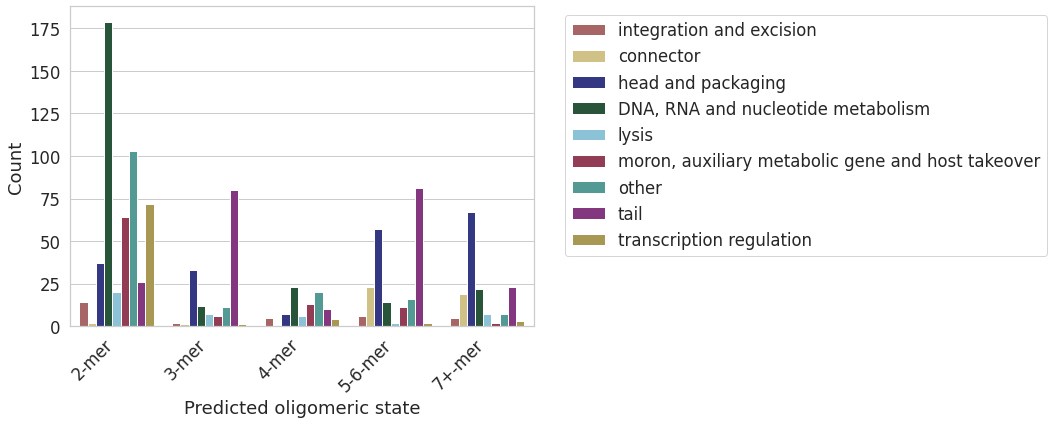

In [18]:
sns.set(style='whitegrid', font_scale=1.5)

# Filter out unknown functions
df = oligomer_predictions[oligomer_predictions['category'] != 'unknown function'].copy()

# Define order of oligomeric states
state_order = [ '2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']
df['prediction_state_bin'] = pd.Categorical(df['prediction_state_bin'],
                                            categories=state_order, ordered=True)

# Define Paul Tol palette matching your legend (in same category order as shown in your image)
tol_colors = [
    "#B35A5A",  # integration and excision
    "#DCC97B",  # connector
    "#272B8F",  # head and packaging
    "#215C39",  # nucleic acid metabolism
    "#7EC8E3",  # lysis
    "#A12E4F",  # morons
    "#49A59E",  # other
    "#8E2B8A",  # tail
    "#B6A145"   # transcription regulation
]

# Ensure the hue order matches your intended category order
category_order = [
    'integration and excision',
    'connector',
    'head and packaging',
    'DNA, RNA and nucleotide metabolism',
    'lysis',
    'moron, auxiliary metabolic gene and host takeover',
    'other',
    'tail',
    'transcription regulation'
]

plt.figure(figsize=(15,6))
sns.countplot(
    data=df,
    x='prediction_state_bin',
    hue='category',
    order=state_order,
    hue_order=category_order,
    palette=tol_colors
)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Predicted oligomeric state")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# Save as PNG
plt.savefig("oligomeric_state_counts.png", dpi=300, bbox_inches="tight")
plt.show()


<ipython-input-19-6479d17cb53c>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


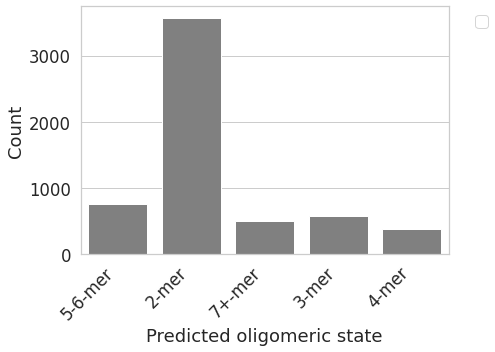

In [19]:
# plot how many there are of each state for the unknown phrogs 
df = oligomer_predictions[oligomer_predictions['category'] == 'unknown function'].copy()
plt.figure(figsize=(7,5))
sns.countplot(df, x = 'prediction_state_bin', color='grey')
plt.xlabel('Predicted oligomeric state')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig("unknown_phrog_oligomeric_states.png", dpi=300, bbox_inches="tight")
plt.tight_layout()


In [22]:
df

,phrog,max_iptm,max_iptm_subunits,prediction_state_bin,category,annot
0,phrog_4989,0.793333,5,5-6-mer,unknown function,NaN
1,phrog_780,0.830000,2,2-mer,unknown function,NaN
2,phrog_3365,0.826667,2,2-mer,unknown function,NaN
4,phrog_18959,0.713333,7,7+-mer,unknown function,NaN
6,phrog_28903,0.736667,7,7+-mer,unknown function,NaN
...,...,...,...,...,...,...
6896,phrog_38247,0.870000,2,2-mer,unknown function,NaN
6897,phrog_31793,0.730000,9,7+-mer,unknown function,NaN
6898,phrog_26853,0.830000,2,2-mer,unknown function,NaN
6899,phrog_18038,0.750000,2,2-mer,unknown function,NaN


In [21]:
df[df['prediction_state_bin'] == '2-mer']

,phrog,max_iptm,max_iptm_subunits,prediction_state_bin,category,annot
1,phrog_780,0.830000,2,2-mer,unknown function,NaN
2,phrog_3365,0.826667,2,2-mer,unknown function,NaN
7,phrog_33785,0.673333,2,2-mer,unknown function,NaN
9,phrog_20742,0.856667,2,2-mer,unknown function,NaN
12,phrog_8907,0.726667,2,2-mer,unknown function,NaN
...,...,...,...,...,...,...
6895,phrog_30525,0.733333,2,2-mer,unknown function,NaN
6896,phrog_38247,0.870000,2,2-mer,unknown function,NaN
6898,phrog_26853,0.830000,2,2-mer,unknown function,NaN
6899,phrog_18038,0.750000,2,2-mer,unknown function,NaN


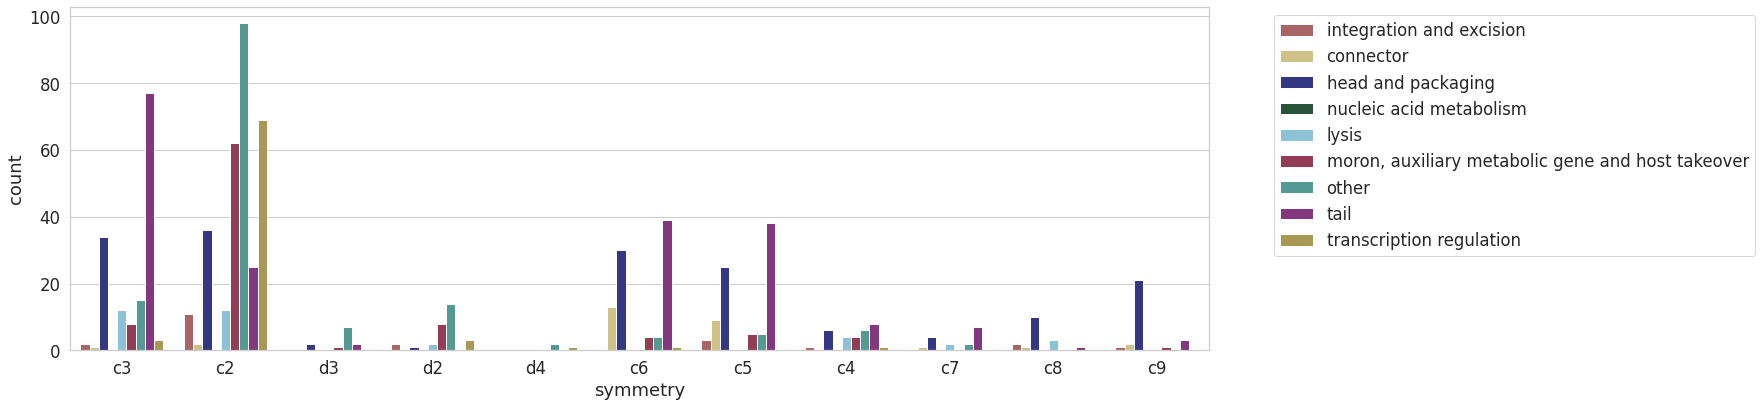

In [86]:
sns.set(style='whitegrid', font_scale=1.5)

# Filter out unknown functions
df = merged_predictions[merged_predictions['category'] != 'unknown function'].copy()


# Define Paul Tol palette matching your legend (in same category order as shown in your image)
tol_colors = [
    "#B35A5A",  # integration and excision
    "#DCC97B",  # connector
    "#272B8F",  # head and packaging
    "#215C39",  # nucleic acid metabolism
    "#7EC8E3",  # lysis
    "#A12E4F",  # morons
    "#49A59E",  # other
    "#8E2B8A",  # tail
    "#B6A145"   # transcription regulation
]

# Ensure the hue order matches your intended category order
category_order = [
    'integration and excision',
    'connector',
    'head and packaging',
    'nucleic acid metabolism',
    'lysis',
    'moron, auxiliary metabolic gene and host takeover',
    'other',
    'tail',
    'transcription regulation'
]

plt.figure(figsize=(25,6))
sns.countplot(
    data=df,
    x='symmetry',
    hue='category',
    hue_order=category_order,
    palette=tol_colors
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

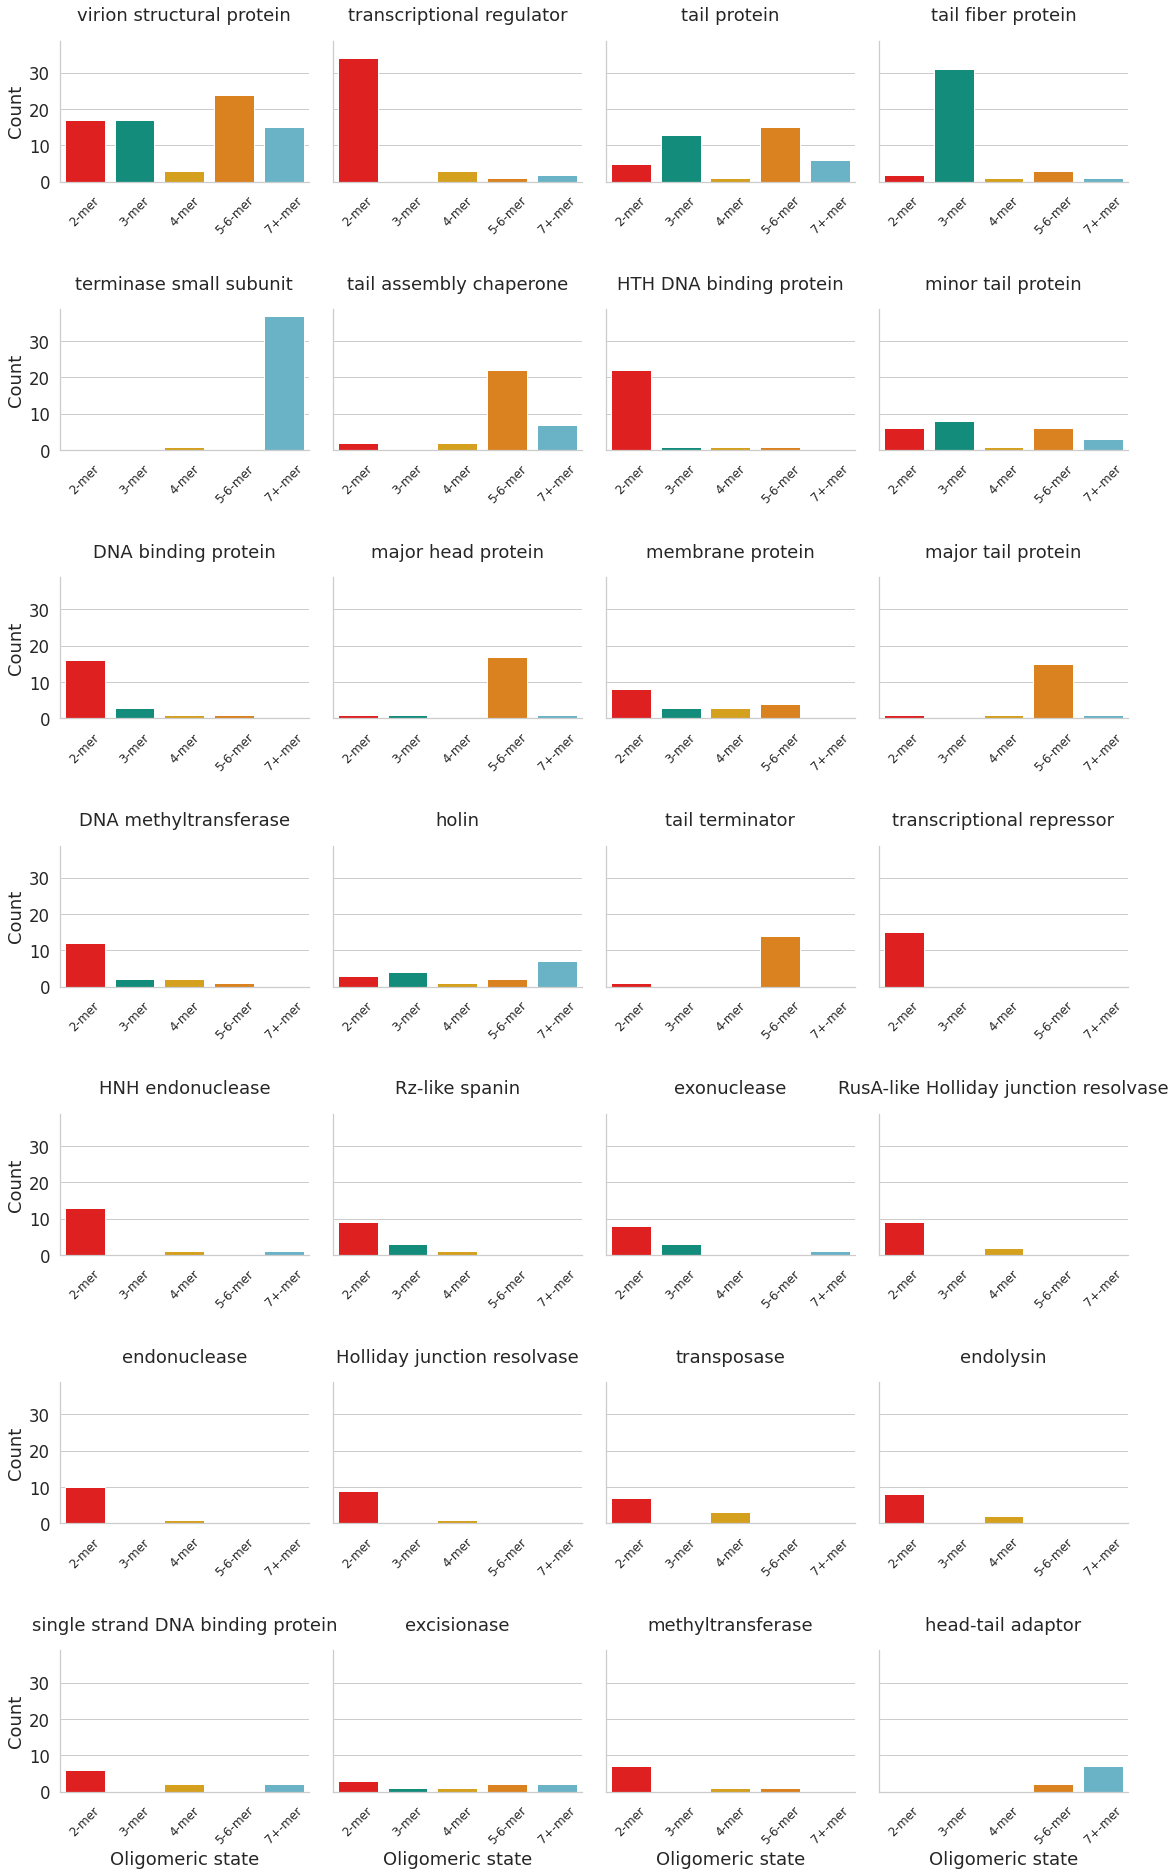

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import wesanderson

# --- config ---
N = 28  # increase how many annotations to show
state_order = ['2-mer', '3-mer', '4-mer', '5-6-mer', '7+-mer']  # adjust if needed

# Filter & pick top-N annotations by frequency
df = oligomer_predictions[oligomer_predictions['category'] != 'unknown function'].copy()
top_annots = df['annot'].value_counts().nlargest(N).index
df_top = df[df['annot'].isin(top_annots)].copy()

# Ensure prediction_state_bin is a categorical with a fixed order
df_top['prediction_state_bin'] = pd.Categorical(
    df_top['prediction_state_bin'],
    categories=state_order,
    ordered=True
)

# Precompute counts so every facet has all states (fill zeros where absent)
counts = (
    df_top.groupby(['annot', 'prediction_state_bin'])
          .size()
          .rename('count')
          .reset_index()
)

# Reindex to include all annot x state combos with zeros where missing
all_idx = pd.MultiIndex.from_product([top_annots, state_order],
                                     names=['annot', 'prediction_state_bin'])
counts = (
    counts.set_index(['annot', 'prediction_state_bin'])
          .reindex(all_idx, fill_value=0)
          .reset_index()
)

# Wes Anderson Darjeeling1 colour palette
palette = wesanderson.film_palette("darjeeling")

# Plot: bar per state per annotation facet
g = sns.catplot(
    data=counts,
    x='prediction_state_bin',
    y='count',
    kind='bar',
    col='annot',
    col_wrap=4,
    order=state_order,
    sharex=False,  # so labels show for all facets
    sharey=True,
    height=3.5,  # slightly taller for more space
    aspect=1.15,
    palette=palette
)
# Make entire figure taller
g.fig.set_size_inches(16, 32)

# Move titles up a bit
g.set_titles("{col_name}", pad=20)
g.set_axis_labels("Oligomeric state", "Count")

# Rotate and pad tick labels
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45, labelsize=12, pad=6)
    ax.set_xticks(range(len(state_order)))
    ax.set_xticklabels(state_order)

# Increase spacing between subplots to avoid overlap
plt.subplots_adjust(top=0.88, bottom=0.12, hspace=0.9)
plt.savefig('../figures/phrogs_28mostannotations.png',  dpi=300, bbox_inches='tight')
plt.show()

# NEXT STEPS 
- Fix this so that each node is a complex not a chain in a complex! 
- Think about what scores mean and plot distributions 
- make a pl

In [8]:
# read in the dataframe of the clustered multimers 

In [18]:
# read in the data 

In [7]:
pairs_report = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/foldseek_multimercluster/search/pairs_report', sep='\t')
pairs = pd.read_csv('/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/foldseek_multimercluster/search/pairs', sep='\t')

In [19]:
import re
import pandas as pd
import numpy as np
import umap
from collections import Counter

# --- helpers ---
complex_re = re.compile(r'^(phrog_\d+\.\d+)')  # captures "phrog_####.##" at start
def complex_id(x: str) -> str:
    m = complex_re.match(str(x))
    return m.group(1) if m else str(x)

def phrog_base(cpx: str) -> str:
    # "phrog_35408.7" -> "phrog_35408"
    return str(cpx).split('.')[0]

# --- Load per-chain results (pairs file from foldseek) ---
pairs = pd.read_csv(
    "/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/one_chain_pairs",
    sep="\t", header=None,
    names=["query", "target", "qTm", "tTm", "assignID"],
    dtype=str
)

# Convert TM scores to numeric and drop rows with missing values
pairs["qTm"] = pd.to_numeric(pairs["qTm"], errors="coerce")
pairs["tTm"] = pd.to_numeric(pairs["tTm"], errors="coerce")
pairs = pairs.dropna(subset=["qTm", "tTm"]).copy()

# Map to complex IDs and compute a symmetric score
pairs["q_complex"] = pairs["query"].map(complex_id)
pairs["t_complex"] = pairs["target"].map(complex_id)
pairs["score"] = (pairs["qTm"] + pairs["tTm"]) / 2.0

# Aggregate chain-level rows to complex-level mean similarity
agg = pairs.groupby(["q_complex", "t_complex"], as_index=False)["score"].mean()

# Build list of complexes and index mapping
complexes = sorted(set(agg["q_complex"]).union(agg["t_complex"]))
idx = {c: i for i, c in enumerate(complexes)}
N = len(complexes)

# Fill symmetric similarity matrix
sim = np.zeros((N, N), dtype=float)
for _, r in agg.iterrows():
    i, j = idx[r["q_complex"]], idx[r["t_complex"]]
    sim[i, j] = max(sim[i, j], r["score"])
    sim[j, i] = max(sim[j, i], r["score"])
np.fill_diagonal(sim, 1.0)

# --- Run UMAP on distances ---
dist = 1.0 - sim
embedding = umap.UMAP(
    metric="precomputed",
    n_neighbors=max(10, int(np.sqrt(N))),
    min_dist=0.05,
    random_state=42
).fit_transform(dist)

# --- Create DataFrame with categories and annotations ---
multimer_embedding = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"], index=complexes)
multimer_embedding["category"] = [phrogs_category.get(phrog_base(c), "unknown function") for c in complexes]
multimer_embedding["annotation"] = [phrogs_annot.get(phrog_base(c), np.nan) for c in complexes]


/home/grig0076/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/grig0076/miniconda3/envs/notebook_env/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/grig0076/miniconda3/envs/notebook_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [20]:
from sklearn.manifold import TSNE
import numpy as np

# Try a smaller perplexity to emphasize local clusters
perp = 20  # Try 10, 15, 20 in separate runs

tsne_xy = TSNE(
    n_components=2,
    metric="precomputed",
    perplexity=perp,
    init="random",
    learning_rate=200,     # 200–400 often good for separation
    random_state=42,
    n_iter=3000,           # more iterations for stability
    verbose=1
).fit_transform(dist)

tsne_embedding = pd.DataFrame(tsne_xy, columns=["TSNE1","TSNE2"], index=complexes)
tsne_embedding["category"]   = [phrogs_category.get(phrog_base(c), "unknown function") for c in complexes]
tsne_embedding["annotation"] = [phrogs_annot.get(phrog_base(c), np.nan) for c in complexes]


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 6729 samples in 0.100s...
[t-SNE] Computed neighbors for 6729 samples in 0.458s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6729
[t-SNE] Computed conditional probabilities for sample 2000 / 6729
[t-SNE] Computed conditional probabilities for sample 3000 / 6729
[t-SNE] Computed conditional probabilities for sample 4000 / 6729
[t-SNE] Computed conditional probabilities for sample 5000 / 6729
[t-SNE] Computed conditional probabilities for sample 6000 / 6729
[t-SNE] Computed conditional probabilities for sample 6729 / 6729
[t-SNE] Mean sigma: 0.211803
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.240120
[t-SNE] KL divergence after 3000 iterations: 2.294909


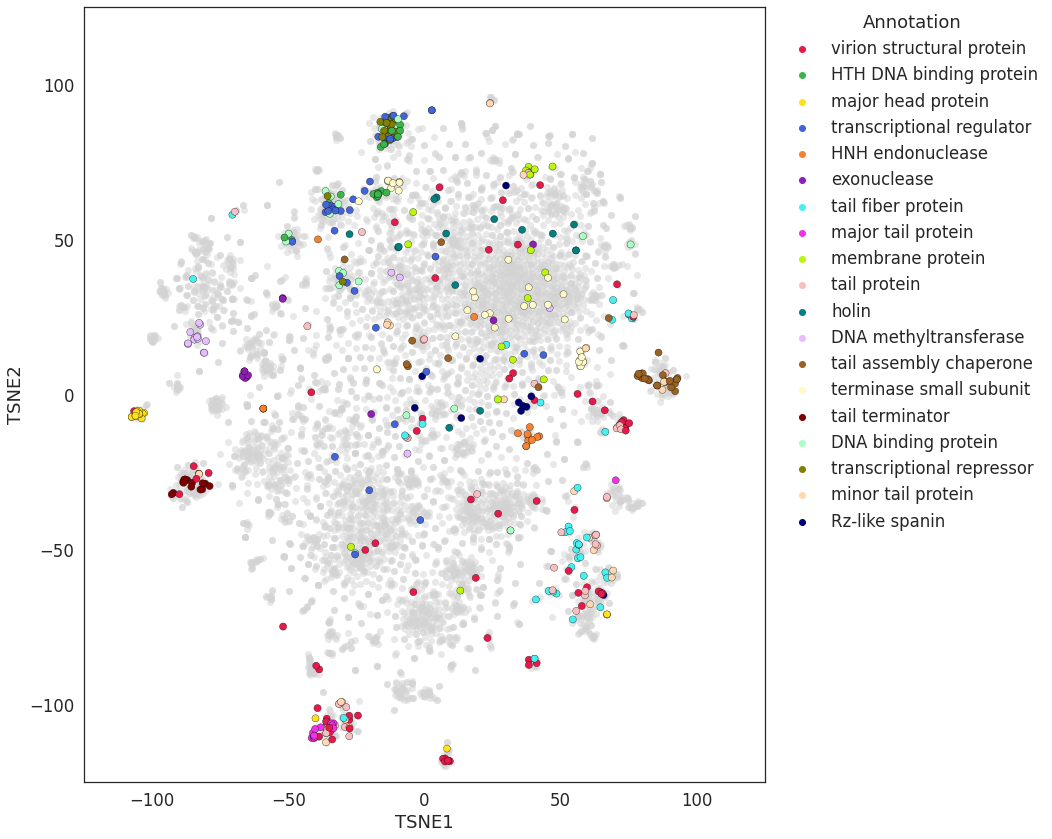

In [22]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


palette2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075']

# Find the top 20 abundant annotations
abundant_annotations = pd.DataFrame.from_dict(
    Counter(tsne_embedding['annotation'].dropna()),
    orient='index'
).sort_values(0, ascending=False)[:19].index.values

# Split known vs. unknown annotations
tsne_embedding_known_annot = tsne_embedding[tsne_embedding['annotation'].isin(abundant_annotations)]
tsne_embedding_unknown_annot = tsne_embedding[~tsne_embedding['annotation'].isin(abundant_annotations)]

plt.figure(figsize=(15, 12))
sns.set(style="white", font_scale=1.5)

# Background points (unknown annotations) in grey
sns.scatterplot(
    data=tsne_embedding_unknown_annot,
    x='TSNE1', y='TSNE2',
    color='#d3d3d3', s=50, linewidth=0, alpha=0.5,
    legend=False
)

# Foreground points (known annotations) with colour-blind palette + black outline
ax = sns.scatterplot(
    data=tsne_embedding_known_annot,
    x='TSNE1', y='TSNE2',
    hue='annotation',
    palette=palette2,
    s=50, edgecolor='black', linewidth=0.3,
    legend='full'
)

# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

# Axes labels and limits
plt.xlim((-125, 125))
plt.ylim((-125, 125))
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.tight_layout()
plt.show()


Same but on the monomers 

In [23]:
import re
import pandas as pd
import numpy as np
import umap
from collections import Counter

# --- helpers ---
complex_re = re.compile(r'^(phrog_\d+\.\d+)')  # captures "phrog_####.##" at start
def complex_id(x: str) -> str:
    m = complex_re.match(str(x))
    return m.group(1) if m else str(x)

def phrog_base(cpx: str) -> str:
    # "phrog_35408.7" -> "phrog_35408"
    return str(cpx).split('.')[0]

# --- Load per-chain results (pairs file from foldseek) ---
pairs = pd.read_csv(
    "/home/grig0076/scratch/phlegm/PHROGs/phrog_representative_structures/phrog_predicted_oligomers/foldseek_monomercluster/pairs",
    sep="\t", header=None,
    names=["query", "target", "qTm", "tTm", "assignID"],
    dtype=str
)

# Convert TM scores to numeric and drop rows with missing values
pairs["qTm"] = pd.to_numeric(pairs["qTm"], errors="coerce")
pairs["tTm"] = pd.to_numeric(pairs["tTm"], errors="coerce")
pairs = pairs.dropna(subset=["qTm", "tTm"]).copy()

# Map to complex IDs and compute a symmetric score
pairs["q_complex"] = pairs["query"].map(complex_id)
pairs["t_complex"] = pairs["target"].map(complex_id)
pairs["score"] = (pairs["qTm"] + pairs["tTm"]) / 2.0

# Aggregate chain-level rows to complex-level mean similarity
agg = pairs.groupby(["q_complex", "t_complex"], as_index=False)["score"].mean()

# Build list of complexes and index mapping
complexes = sorted(set(agg["q_complex"]).union(agg["t_complex"]))
idx = {c: i for i, c in enumerate(complexes)}
N = len(complexes)

# Fill symmetric similarity matrix
sim = np.zeros((N, N), dtype=float)
for _, r in agg.iterrows():
    i, j = idx[r["q_complex"]], idx[r["t_complex"]]
    sim[i, j] = max(sim[i, j], r["score"])
    sim[j, i] = max(sim[j, i], r["score"])
np.fill_diagonal(sim, 1.0)

# --- Run UMAP on distances ---
dist = 1.0 - sim
embedding = umap.UMAP(
    metric="precomputed",
    n_neighbors=max(10, int(np.sqrt(N))),
    min_dist=0.05,
    random_state=42
).fit_transform(dist)

# --- Create DataFrame with categories and annotations ---
monomer_embedding = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"], index=complexes)
monomer_embedding["category"] = [phrogs_category.get(phrog_base(c), "unknown function") for c in complexes]
monomer_embedding["annotation"] = [phrogs_annot.get(phrog_base(c), np.nan) for c in complexes]


/home/grig0076/miniconda3/envs/notebook_env/lib/python3.9/site-packages/umap/umap_.py:1857: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/grig0076/miniconda3/envs/notebook_env/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [24]:
# Try a smaller perplexity to emphasize local clusters
perp = 20  # Try 10, 15, 20 in separate runs

tsne_xy = TSNE(
    n_components=2,
    metric="precomputed",
    perplexity=perp,
    init="random",
    learning_rate=200,     # 200–400 often good for separation
    random_state=42,
    n_iter=3000,           # more iterations for stability
    verbose=1
).fit_transform(dist)

tsne_embedding = pd.DataFrame(tsne_xy, columns=["TSNE1","TSNE2"], index=complexes)
tsne_embedding["category"]   = [phrogs_category.get(phrog_base(c), "unknown function") for c in complexes]
tsne_embedding["annotation"] = [phrogs_annot.get(phrog_base(c), np.nan) for c in complexes]


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 6685 samples in 0.097s...
[t-SNE] Computed neighbors for 6685 samples in 0.455s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6685
[t-SNE] Computed conditional probabilities for sample 2000 / 6685
[t-SNE] Computed conditional probabilities for sample 3000 / 6685
[t-SNE] Computed conditional probabilities for sample 4000 / 6685
[t-SNE] Computed conditional probabilities for sample 5000 / 6685
[t-SNE] Computed conditional probabilities for sample 6000 / 6685
[t-SNE] Computed conditional probabilities for sample 6685 / 6685
[t-SNE] Mean sigma: 0.207017
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.068985
[t-SNE] KL divergence after 3000 iterations: 2.287837


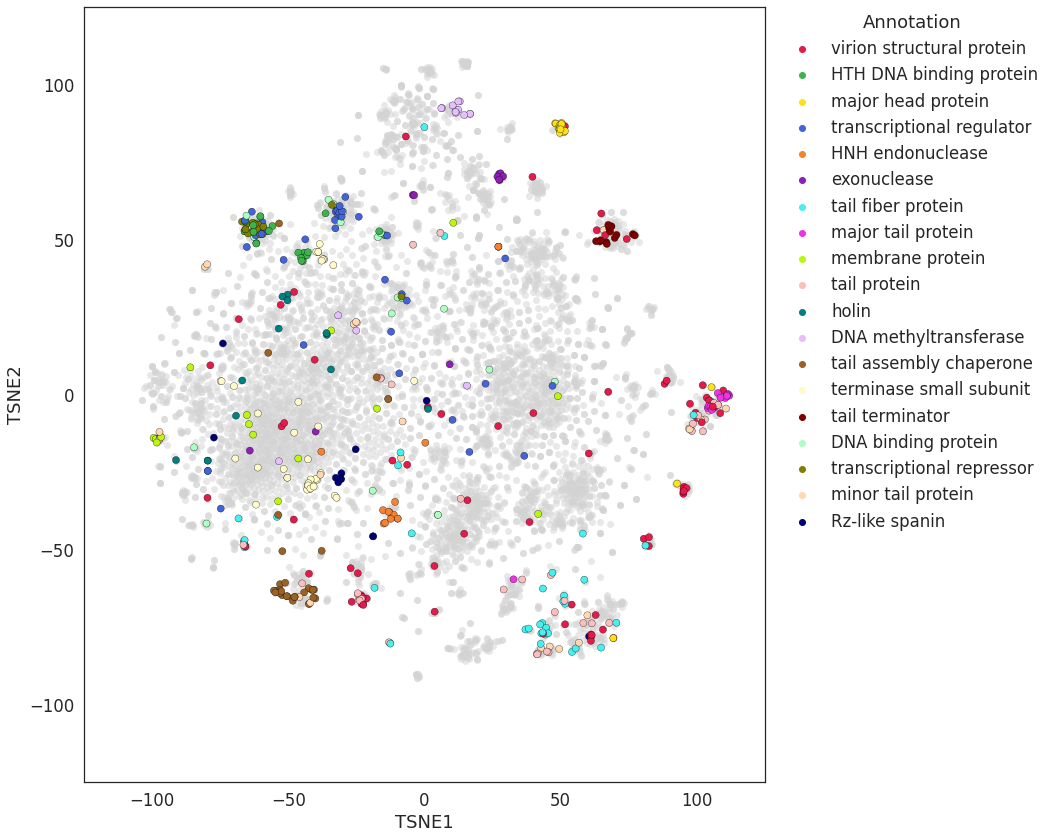

In [25]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


palette2 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075']

# Find the top 20 abundant annotations
abundant_annotations = pd.DataFrame.from_dict(
    Counter(tsne_embedding['annotation'].dropna()),
    orient='index'
).sort_values(0, ascending=False)[:19].index.values

# Split known vs. unknown annotations
tsne_embedding_known_annot = tsne_embedding[tsne_embedding['annotation'].isin(abundant_annotations)]
tsne_embedding_unknown_annot = tsne_embedding[~tsne_embedding['annotation'].isin(abundant_annotations)]

plt.figure(figsize=(15, 12))
sns.set(style="white", font_scale=1.5)

# Background points (unknown annotations) in grey
sns.scatterplot(
    data=tsne_embedding_unknown_annot,
    x='TSNE1', y='TSNE2',
    color='#d3d3d3', s=50, linewidth=0, alpha=0.5,
    legend=False
)

# Foreground points (known annotations) with colour-blind palette + black outline
ax = sns.scatterplot(
    data=tsne_embedding_known_annot,
    x='TSNE1', y='TSNE2',
    hue='annotation',
    palette=palette2,
    s=50, edgecolor='black', linewidth=0.3,
    legend='full'
)

# Move legend to the right
plt.legend(
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0,
    frameon=False,
    title="Annotation"
)

# Axes labels and limits
plt.xlim((-125, 125))
plt.ylim((-125, 125))
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.tight_layout()
plt.show()